### 0: Download and unzip data

In [ ]:
# Download and unzip data
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_Data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_GroundTruth.csv
!unzip "./ISBI2016_ISIC_Part3_Test_Data.zip"
!unzip "./ISBI2016_ISIC_Part3_Training_Data.zip"

# Install additional library
!pip install -U albumentations

## 1: Import

In [ ]:
# Standard library imports
import os
import shutil
import math
import copy
import random
import gc

# Third-party imports for data handling and scientific computation
import cv2
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
import albumentations as Augm
from albumentations.pytorch import ToTensorV2
from albumentations.augmentations.transforms import ColorJitter, FancyPCA

# PyTorch imports for deep learning
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR, ExponentialLR, ReduceLROnPlateau, CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50 as _resnet50
from torchsummary import summary

# Other utilities
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 2: Data Loading

In [ ]:
########## ONLY RUN THIS CELL CAN ONCE ##########
# Remove if exists, and create train, unlabeled val, test folders
train_path = "./train"
unlabeled_path = "./unlabeled"
val_path = "./val"

for path in [train_path, unlabeled_path, val_path]:
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

for path in [train_path, val_path]:
    os.makedirs(os.path.join(path, "benign"))
    os.makedirs(os.path.join(path, "malignant"))

# Copy images to train, unlabeled, val folders
df = pd.read_csv("./ISBI2016_ISIC_Part3_Training_GroundTruth.csv")
img_lis = []
lbl_lis = []
img_lis.append("ISIC_0000000")
lbl_lis.append("benign")
for i in range(len(df)):
    name, label = df["ISIC_0000000"][i], df["benign"][i]
    img_lis.append(name)
    lbl_lis.append(label)

# Define the number of images in each category
N_total = len(img_lis)
N_train = 270
N_unlabeled = 540

# Shuffle the data and split into train, unlabeled, val
shuffle_ix = np.random.permutation(np.arange(N_total))
ix_train = shuffle_ix[:N_train]
ix_unlabeled = shuffle_ix[N_train : N_train + N_unlabeled]
ix_val = shuffle_ix[N_train + N_unlabeled:]

for i in ix_train:
    name, label = img_lis[i], lbl_lis[i]
    shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/"+name+".jpg", "./train/"+label+"/"+name+".jpg")
for i in ix_unlabeled:
    name = img_lis[i]
    shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/"+name+".jpg", "./unlabeled/"+name+".jpg")
for i in ix_val:
    name, label = img_lis[i], lbl_lis[i]
    shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/"+name+".jpg", "./val/"+label+"/"+name+".jpg")  

# Print out the number of images in each folder
print(f'Number of images: {len(img_lis)}')
print(f'Number of training images: {len(ix_train)}')
print(f'Number of unlabeled images: {len(ix_unlabeled)}')
print(f'Number of validation images: {len(ix_val)}')

Number of images: 900
Number of training images: 270
Number of unlabeled images: 540
Number of validation images: 90


## 3: Data Preprocessing and Dataloaders

### 3.1: Upsampling

In [ ]:
# Define the paths
benign_train_dir = "./train/benign"
malignant_train_dir = "./train/malignant"

benign_val_dir = "./val/benign"
malignant_val_dir = "./val/malignant"

# Sort the filepaths
benign_train_filepaths = sorted([os.path.join(benign_train_dir, f) for f in os.listdir(benign_train_dir)])
malignant_train_filepaths = sorted([os.path.join(malignant_train_dir, f) for f in os.listdir(malignant_train_dir)])

benign_val_filepaths = sorted([os.path.join(benign_val_dir, f) for f in os.listdir(benign_val_dir)])
malignant_val_filepaths = sorted([os.path.join(malignant_val_dir, f) for f in os.listdir(malignant_val_dir)])

# Augment the minority class
# Excluding benign filepaths or too balanced might cause nan/inf values in training
aug_train_filepaths = [*benign_train_filepaths, *malignant_train_filepaths, *malignant_train_filepaths]
aug_train_filepaths = [i for i in aug_train_filepaths if cv2.imread(i) is not None]

aug_val_filepaths = [*benign_val_filepaths, *malignant_val_filepaths, *malignant_val_filepaths]
aug_val_filepaths = [i for i in aug_val_filepaths if cv2.imread(i) is not None]

# Shuffle the filepaths
random.seed(42)
random.shuffle(aug_train_filepaths)
random.shuffle(aug_val_filepaths)

# Explore the data
print(f'Training:\n'
      f'Benign images: {len(benign_train_filepaths)}\n'
      f'Malignant images: {len(malignant_train_filepaths)}\n'
      f'\n'
      f'Validation:\n'
      f'Benign images: {len(benign_val_filepaths)}\n'
      f'Malignant images: {len(malignant_val_filepaths)}')

Training:
Benign images: 220
Malignant images: 50

Validation:
Benign images: 75
Malignant images: 15


### 3.2: Augmentation

In [ ]:
# Augmented Data Set
class AugmentedDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        label = 1.0 if os.path.normpath(image_filepath).split(os.sep)[-2] == "malignant" else 0.0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label
    
# Augmentations
normalization = transforms.Compose([
    transforms.Resize(244),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

aug_normalization = transforms.Compose([
    transforms.Resize(244),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.5, contrast=1, saturation=0.1, hue=0.5),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.65, std=0.5)
])

# Flipping
GEO = Augm.Compose([
    Augm.Resize(224, 224),
    Augm.RandomCrop(width=224, height=224),
    Augm.HorizontalFlip(p=1),
    Augm.RandomBrightnessContrast(p=0.1),
    ToTensorV2()
])

# Color Jitter
COL = Augm.Compose([
    Augm.Resize(224, 224),
    Augm.RandomCrop(width=224, height=224),
    ColorJitter(),
    Augm.RandomBrightnessContrast(p=0.1),
    ToTensorV2()
])

# PCA
PCA = Augm.Compose([
    Augm.Resize(224, 224),
    Augm.RandomCrop(width=224, height=224),
    FancyPCA(),
    Augm.RandomBrightnessContrast(p=0.1),
    ToTensorV2()
])

# Create augmented datasets
# Augmented training data
GEO_train_dataset = AugmentedDataset(images_filepaths=aug_train_filepaths, transform=GEO)
COL_train_dataset = AugmentedDataset(images_filepaths=aug_train_filepaths, transform=COL)
PCA_train_dataset = AugmentedDataset(images_filepaths=aug_train_filepaths, transform=PCA)
# Augmented validation data
GEO_val_dataset = AugmentedDataset(images_filepaths=aug_val_filepaths, transform=GEO)
COL_val_dataset = AugmentedDataset(images_filepaths=aug_val_filepaths, transform=COL)
PCA_val_dataset = AugmentedDataset(images_filepaths=aug_val_filepaths, transform=PCA)

# Combine datasets
aug_train_dataset = [GEO_train_dataset, COL_train_dataset, PCA_train_dataset]
aug_train_dataset = ConcatDataset(aug_train_dataset)        # Remove GEO_train_dataset
aug_val_dataset = [GEO_val_dataset, COL_val_dataset, PCA_val_dataset]
aug_val_dataset = ConcatDataset(aug_val_dataset)            # Remove GEO_val_dataset

# Before and after augmentation
print(f'Training images before: {len(ix_train)}')
print(f'Training images after: {len(aug_train_dataset) + len(ix_train)}')
print(f'Validation images before: {len(ix_val)}')
print(f'Validation images after: {len(aug_val_dataset) + len(ix_val)}')

Training images before: 270
Training images after: 1230
Validation images before: 90
Validation images after: 405



### 3.3: Dataloaders

In [48]:
# Unlabeled dataset for ImageFolder problem
class UnlabeledDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = self._gather_unlabeled_samples(root)

    def _gather_unlabeled_samples(self, root):
        samples = []
        for filename in os.listdir(root):
            if filename.endswith(".jpg"):
                path = os.path.join(root, filename)
                samples.append((path, -1))  # -1 indicates no label is provided
        return samples

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = Image.open(path).convert('RGB')
        img = self.transform(img) if self.transform is not None else img
        return img, target

    def __len__(self):
        return len(self.samples)

# Data loaders for all datasets
def dataloader(batch_size=12, augment=False):
    # Use augmented data for training if required
    if augment:
        train_dataset = ConcatDataset([ImageFolder('./train', transform=normalization), aug_train_dataset])
    else:
        train_dataset = ImageFolder('./train', transform=aug_normalization)
        
    val_dataset = ImageFolder('./val', transform=normalization)
    unlabeled_dataset = UnlabeledDataset('./unlabeled', transform=normalization)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    unlabeled_loader = DataLoader(dataset=unlabeled_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    # It takes time to count!
    # Counts for augmented training set
    benign_train_aug_count = sum([1 for _, label in train_dataset if label == 0.0])
    malignant_train_aug_count = sum([1 for _, label in train_dataset if label == 1.0])

    # Counts for augmented validation set
    benign_val_aug_count = sum([1 for _, label in val_dataset if label == 0.0])
    malignant_val_aug_count = sum([1 for _, label in val_dataset if label == 1.0])

    print(f'After augmentation:\n'
          f'Training:\n'
          f'Benign images: {benign_train_aug_count}\n'
          f'Malignant images: {malignant_train_aug_count}\n'
          f'\n'
          f'Validation:\n'
          f'Benign images: {benign_val_aug_count}\n'
          f'Malignant images: {malignant_val_aug_count}\n')

    return train_loader, unlabeled_loader, val_loader

# Load data
batch_size = 32
train_loader, unlabeled_loader, val_loader = dataloader(batch_size, augment=True)

# Checkpoint
print(f'Shape of image: {train_loader.dataset[0][0].shape}')
print(f'Number of training batches: {len(train_loader)}')
print(f'Number of unlabeled batches: {len(unlabeled_loader)}')
print(f'Number of validation batches: {len(val_loader)}')

After augmentation:
Training:
Benign images: 880
Malignant images: 350

Validation:
Benign images: 75
Malignant images: 15

Shape of image: torch.Size([3, 224, 224])
Number of training batches: 39
Number of unlabeled batches: 17
Number of validation batches: 3


## 4: Build the models

### 4.1: ResNet-50

In [49]:
# 3x3 Convolutional Layer
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

# Basic Block with 2 Convolutional Layers
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# Bottleneck Block with 3 Convolutional Layers
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# Customized ResNet Architecture
class ResNet(nn.Module):
    def __init__(self, block, layers, use_fc=False, dropout=None):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.use_fc = use_fc
        self.use_dropout = True if dropout else False
        if self.use_fc:
            print('Using fc.')
            self.fc_add = nn.Linear(512*block.expansion, 512)
        if self.use_dropout:
            print(f'Using dropout. p = {dropout}')
            self.dropout = nn.Dropout(p=dropout)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x, *args):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.mean(dim=(-2, -1))
        x = x.view(x.size(0), -1)
        if self.use_fc:
            x = F.relu(self.fc_add(x))
        if self.use_dropout:
            x = self.dropout(x)
        return x

# Create ResNet50 Model with / without Pre-trained Weights and dropout
def get_resnet50(pre_trained=True):
    Resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], dropout=0.5)    # Dropout control (Default: None)
    if pre_trained:
        pre_trained_model = _resnet50(weights = "IMAGENET1K_V2")
        pre_trained = pre_trained_model.state_dict()
        new_weights = {k: pre_trained[k] for k in Resnet50.state_dict()}
        Resnet50.load_state_dict(new_weights)
    return Resnet50

# Define the high-level model
class ResnetModel(nn.Module):
    def __init__(self, encoder, num_classes=1):
        super(ResnetModel, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(2048, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        x = self.sigmoid(x)
        return x
    
resnet50 = get_resnet50(pre_trained=True)
resnet_model = ResnetModel(resnet50, 1)
resnet_model = resnet_model.to(device)

# Print the summary
input_size = (3, 224, 224)  # Input size for ResNet-50 model (channels, height, width)
#summary(model, input_size)

Using dropout. p = 0.5


### 4.2: Focal Loss

In [50]:
# Focal Loss for Imbalanced Data
# Alpha should be about the ratio of the classes, ratio = alpha : 1 - alpha
# e.g. alpha = 0.75 for 3:1 ratio
class BCEFocalLoss(nn.Module):
    def __init__(self, gamma=3.0, alpha=0.75, reduction='mean'):
        super(BCEFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, target):
        alpha = self.alpha
        gamma = self.gamma
        loss = - alpha * (1 - logits) ** gamma * target * torch.log(logits) - \
               (1 - alpha) * logits ** gamma * (1 - target) * torch.log(1 - logits)
        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()
        return loss

### 4.3: Mean Teacher Model

In [62]:
# Mean Teacher Model
# Student model would be ResNet50 model
class MeanTeacherModel(nn.Module):
    # Core
    def __init__(self, student_model, ema_decay):
        super().__init__()
        self.student_model = student_model
        self.teacher_model = copy.deepcopy(student_model)
        self.ema_decay = ema_decay

    def forward(self, x):
        return self.student_model(x)

    def update_teacher_model(self, current_epoch, momentum=0.9995):
        momentum = min(1 - 1/(current_epoch+1), self.ema_decay)
        with torch.no_grad():
            for student_params, teacher_params in zip(self.student_model.parameters(), self.teacher_model.parameters()):
                teacher_params.data.mul_(momentum).add_((1 - momentum) * student_params.data)

    # Adjust the weight of the consistency loss to rely on teacher's prediction
    # The weight factor decreases from 1 to 0 during the first 15 epochs
    def sigmoid_rampup(self, current_epoch):
        current_epoch = np.clip(current_epoch, 0.0, 5.0)
        phase = 1.0 - current_epoch / 5.0
        return np.exp(-5.0 * phase * phase).astype(np.float32)

    # The weight decreases from 100
    def get_consistency_weight(self, epoch):
        return 50*self.sigmoid_rampup(epoch)

## 5: Training

In [63]:
# Define the function to train the model
def train_mean_teacher(model, labeled_loader, unlabeled_loader, val_loader, optimizer, scheduler,
                       consistency_criterion, supervised_criterion, device, epochs, batch_size):
    # Clear GPU cache
    if torch.cuda.is_available():
        gc.collect()
        torch.cuda.empty_cache()

    loss_train_list = []
    loss_supervised_list = []
    loss_const_list = []
    auc_train_list = []
    acc_train_list = []
    auc_val_list = []
    acc_val_list = []

    model.teacher_model.train()
    
    for epoch in range(epochs):
        # Training
        model.student_model.train()

        unlabeled_lbl = []
        unlabeled_pred = []
        total_loss_train = 0
        super_loss_train = 0
        const_loss_train = 0
    
        for (labeled_imgs, labeled_targets), (unlabeled_imgs, _) in zip(labeled_loader, unlabeled_loader):
            labeled_imgs = labeled_imgs.float().to(device)
            labeled_targets = labeled_targets.float().unsqueeze(1).to(device)
            unlabeled_imgs = unlabeled_imgs.float().to(device)
            
            optimizer.zero_grad()

            # Labeled data
            labeled_preds = model.student_model(labeled_imgs)
            supervised_loss = supervised_criterion(labeled_preds, labeled_targets)
            #print(supervised_loss)

            # Unlabeled data
            unlabeled_preds_student = model.student_model(unlabeled_imgs)
            with torch.no_grad():
                unlabeled_preds_teacher = model.teacher_model(unlabeled_imgs)
                
            unlabeled_pred.extend(unlabeled_preds_student.detach().cpu().numpy())
            unlabeled_lbl.extend(np.around(unlabeled_preds_teacher.detach().cpu().numpy())) 

            # Consistency loss and total loss
            consistency_weights = model.get_consistency_weight(epoch)
            consistency_loss = consistency_weights\
                * consistency_criterion(unlabeled_preds_student, unlabeled_preds_teacher)
            #print(consistency_loss)

            total_loss = supervised_loss + consistency_loss

            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()
 
            # Update teacher model parameters
            model.update_teacher_model(current_epoch=epoch)
            total_loss_train += total_loss.item()
            super_loss_train += supervised_loss.item()
            const_loss_train += consistency_loss.item()

        # Unlabeled metrics
        unlabeled_lbl, unlabeled_pred = np.array(unlabeled_lbl), np.array(unlabeled_pred)
        # Check for NaN in the labels
        if np.isnan(unlabeled_lbl).any() or np.isnan(unlabeled_pred).any():
            print(f"NaN values found in unlabeled_lbl/pred for epoch {epoch+1}. Skip calculating metrics.")
            acc_train, auc_train = np.nan, np.nan
        else:
            acc_train = accuracy_score(unlabeled_lbl, np.round(unlabeled_pred))
            if len(np.unique(unlabeled_lbl)) > 1:
                auc_train = roc_auc_score(unlabeled_lbl, unlabeled_pred)
            else:
                print(f"Only one class present in unlabeled_lbl/pred for epoch {epoch+1}, AUC is not defined.")
                auc_train = np.nan
        acc_train_list.append(acc_train)
        auc_train_list.append(auc_train)

        # Validation
        model.student_model.eval()

        val_lbl = []
        val_pred = []
        
        for (imgs, targets) in val_loader:
            imgs = imgs.float().to(device)
            targets = targets.float().unsqueeze(1).to(device)
            preds = model.student_model(imgs)
            val_pred.extend(preds.detach().cpu().numpy())
            val_lbl.extend(targets.detach().cpu().numpy())
        
        # Validation metrics
        val_lbl, val_pred = np.array(val_lbl), np.array(val_pred)
        # Check for NaN in the labels
        if np.isnan(val_lbl).any() or np.isnan(val_pred).any():
            print(f"NaN values found in val_lbl/pred for epoch {epoch+1}. Skip calculating metrics.")
            acc_val, auc_val = np.nan, np.nan
        else:
            acc_val = accuracy_score(val_lbl, np.round(val_pred))
            if len(np.unique(val_lbl)) > 1:
                auc_val = roc_auc_score(val_lbl, val_pred)
            else:
                print(f"Only one class present in val_lbl/pred for epoch {epoch+1}, AUC is not defined.")
                auc_val = np.nan
        acc_val_list.append(acc_val)
        auc_val_list.append(auc_val)

        loss_train_list.append(total_loss_train)
        loss_const_list.append(const_loss_train)
        loss_supervised_list.append(super_loss_train)

        # Learning rate scheduler
        scheduler.step()

        # Epoch summary
        print(f"Epoch [{epoch+1:02}/{epochs}],   "
              f"Loss: {total_loss_train/len(labeled_loader):.4f},   "
              f"Train Acc: {acc_train*100:.2f}%,   "
              f"Train AUC: {auc_train:.4f},   "
              f"Val Acc: {acc_val*100:.2f}%,   "
              f"Val AUC: {auc_val:.4f}")

        # Clear GPU cache
        if torch.cuda.is_available():
            gc.collect()
            torch.cuda.empty_cache()

    return model, loss_train_list, loss_const_list, loss_supervised_list, acc_train_list, auc_train_list, acc_val_list, auc_val_list

# Load ResNet50 as Student model and Mean Teacher model
resnet_model = get_resnet50(pre_trained=True)
base_model = ResnetModel(resnet_model, 1)
base_model = base_model.to(device)

mean_teacher_model = MeanTeacherModel(base_model, ema_decay=0.99)
mean_teacher_model = mean_teacher_model.to(device)

# Optimizer and loss functions
optimizer = Adam(mean_teacher_model.parameters(), lr=1e-4, weight_decay=1e-5)
consistency_criterion = nn.MSELoss()
supervised_criterion = BCEFocalLoss()

epochs = 15
scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=epochs)

# Run training
mean_teacher_model, loss_train_list, loss_const_list, loss_supervised_list, acc_train_list,\
auc_train_list, acc_val_list, auc_val_list = train_mean_teacher(
    mean_teacher_model, train_loader, unlabeled_loader, val_loader, optimizer, scheduler,
    consistency_criterion, supervised_criterion, device, epochs, batch_size
)

Using dropout. p = 0.5
Epoch [01/15],   Loss: 0.0140,   Train Acc: 69.07%,   Train AUC: 0.7612,   Val Acc: 81.11%,   Val AUC: 0.4311
Epoch [02/15],   Loss: 0.0116,   Train Acc: 77.04%,   Train AUC: 0.8422,   Val Acc: 81.11%,   Val AUC: 0.5387
Epoch [03/15],   Loss: 0.0142,   Train Acc: 82.59%,   Train AUC: 0.9136,   Val Acc: 82.22%,   Val AUC: 0.4240
Epoch [04/15],   Loss: 0.0205,   Train Acc: 84.07%,   Train AUC: 0.9219,   Val Acc: 82.22%,   Val AUC: 0.5902
Epoch [05/15],   Loss: 0.0255,   Train Acc: 86.85%,   Train AUC: 0.9457,   Val Acc: 82.22%,   Val AUC: 0.6533
Epoch [06/15],   Loss: 0.0251,   Train Acc: 87.78%,   Train AUC: 0.9392,   Val Acc: 82.22%,   Val AUC: 0.6071
Epoch [07/15],   Loss: 0.0209,   Train Acc: 87.78%,   Train AUC: 0.9521,   Val Acc: 82.22%,   Val AUC: 0.5547
Epoch [08/15],   Loss: 0.0203,   Train Acc: 87.22%,   Train AUC: 0.9404,   Val Acc: 83.33%,   Val AUC: 0.5796
Epoch [09/15],   Loss: 0.0181,   Train Acc: 85.19%,   Train AUC: 0.9422,   Val Acc: 82.22%,   Val

## 6: Results

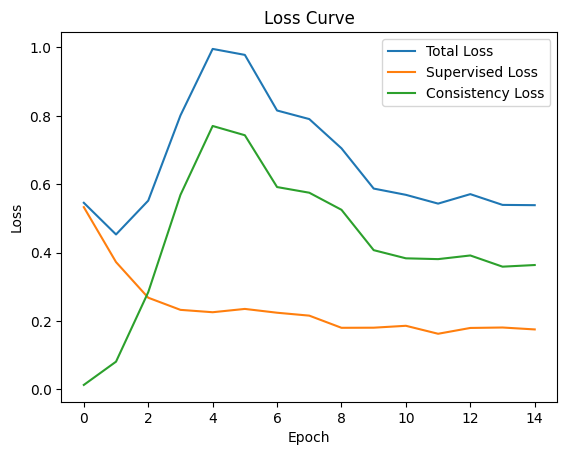

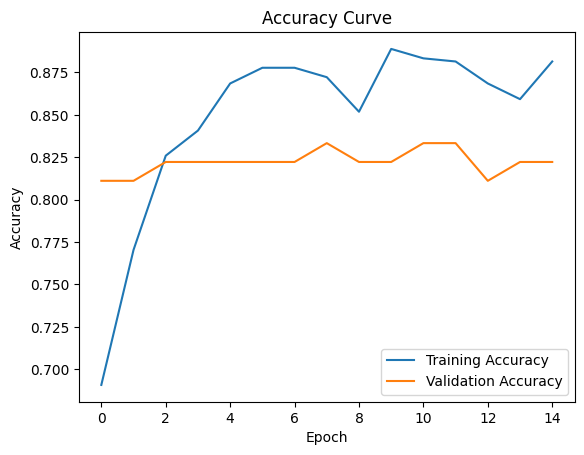

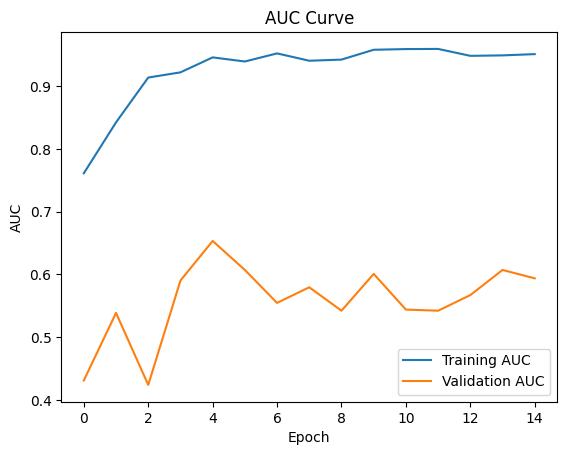

In [64]:
# Plot loss curve
fig = plt.figure()
plt.plot(loss_train_list, label='Total Loss')
plt.plot(loss_supervised_list, label='Supervised Loss')
plt.plot(loss_const_list, label='Consistency Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Plot accuracy curve
fig = plt.figure()
plt.plot(acc_train_list, label='Training Accuracy')
plt.plot(acc_val_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# Plot AUC curve
fig = plt.figure()
plt.plot(auc_train_list, label='Training AUC')
plt.plot(auc_val_list, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC Curve')
plt.legend()
plt.show()